# Final Project: Inpainting via HRBF
# SCC0251 - Processamento de Imagens
---

### Nome: Guilherme Valderramos Montroni
### Nº USP: 13062539
---


#**Packages**

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import numpy.matlib

from scipy.spatial import distance_matrix

#**Functions**

In [ ]:
# NORMALIZE
def normalize(img, factor):
    img_min = np.min(img)                         # min of image
    img_max = np.max(img)                         # max of image
    img = (img - img_min)/(img_max-img_min)       # normalize of image between 0 and 1
    return (img*factor)

In [ ]:
def rhs_function(img, mask):


  # Single Color Channel (SCC)
  if (len(img.shape) == 2):
    gx, gy = np.gradient(img)                           # cradient calculation
    rhs = np.array([*img[mask], *gx[mask], *gy[mask]])  # rhs of scc image

  # RGB
  if (len(img.shape) == 3):
    gx, gy = np.gradient(img)                           # DÚVIDA P/ PRÓXIMA ETAPA 
    rhs = print('ainda não foi feito para imagem rbg')  # como calcular o gradiente de uma imagem colorida?
  
  return (rhs)

In [ ]:
# GRID 
def grid(mask):
  
  # shape image
  M,N = mask.shape                    

  # creating the grid
  x = np.linspace(0, M-1, M)
  y = np.linspace(0, N-1, N)
  X, Y = np.meshgrid(x, y)

  idx = np.flip(np.array([X.flatten(), Y.flatten()]).T,1).reshape(M,N,2)    # index of image

  return (idx)

In [ ]:
# RGB TO GRAY 
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
# Euclidean Distance
def Euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return dist

In [ ]:
# Non-Damaged and Damaged Points
def non_and_damaged(img, mask):
  
  # by pattern, the degraded region is black
  nondamaged = img[mask]
  damaged = img[~mask]

  return (nondamaged, damaged)

In [ ]:
# Hermite RBF Interpolation Digital Inpainting
# dsites (array Nx2): N pontos dados onde se tem os valores da função. (região da imagem que não está degradada)
# epoints (array Mx2): M pontos onde a função interpoladora será calculada. (região degradada da imagem)
# rhs (array 3Nx1): valores e derivadas da função nos pontos dsites.
def HRBF2D(dsites, epoints, rhs, kernel):

    rbf, dxrbf, dyrbf, dxxrbf, dyyrbf, dxyrbf, ep = kernel['rbf'], kernel['dxrbf'], kernel['dyrbf'], kernel['dxxrbf'], kernel['dyyrbf'], kernel['dxyrbf'], kernel['ep']
    
    # Compute the distance and difference matrices for evaluation matrix
    DM_eval = distance_matrix(epoints, dsites)
    dx_eval = epoints[:,0].reshape(-1,1) - dsites[:,0].reshape(1,-1)
    dy_eval = epoints[:,1].reshape(-1,1) - dsites[:,1].reshape(1,-1)

    # Compute the distance and difference matrices for interpolation matrix
    DM_data = distance_matrix(dsites, dsites)
    dx_data = dsites[:,0].reshape(-1,1) - dsites[:,0].reshape(1,-1)
    dy_data = dsites[:,1].reshape(-1,1) - dsites[:,1].reshape(1,-1)

    # Compute blocks for interpolation matrix
    IM    = rbf(ep, DM_data)
    DxIM  = dxrbf(ep, DM_data, dx_data)
    DyIM  = dyrbf(ep, DM_data, dy_data)
    DxxIM = dxxrbf(ep, DM_data, dx_data)
    DyyIM = dyyrbf(ep, DM_data, dy_data)
    DxyIM = dxyrbf(ep, DM_data, dx_data, dy_data)

    IM = np.block([[IM,   -DxIM,  -DyIM],
                   [DxIM, -DxxIM, -DxyIM],
                   [DyIM, -DxyIM, -DyyIM]])

    # Compute blocks for evaluation matrix
    EM    = rbf(ep, DM_eval)
    DxEM  = dxrbf(ep, DM_eval, dx_eval)
    DyEM  = dyrbf(ep, DM_eval, dy_eval)

    # Assemble evaluation matrix
    EM = np.block([EM, -DxEM, -DyEM])

    # RBF Hermite interpolant
    alpha = np.linalg.solve(IM, rhs)
    return EM @ alpha

#**Input**

In [ ]:
filename = str(input().rstrip())                          # file of input image
original_img = imageio.imread(filename).astype(np.uint8)  # uint8 elements

filename = str(input().rstrip())                          # file of input image
img = imageio.imread(filename).astype(np.uint8)           # uint8 elements

filename = str(input().rstrip())                          # file of input mask
mask = imageio.imread(filename).astype(bool)              # logical elements

walk.png
walk1.png
walk2.png


In [ ]:
original_img = rgb2gray(original_img).round().astype(np.uint8)
img = rgb2gray(img).round().astype(np.uint8)
print(mask.shape)

(300, 300, 4)


In [ ]:
print(original_img.dtype)
print(img.dtype)
print(mask.dtype)

uint8
uint8
bool


In [ ]:
mask = mask[:,:,0]
print(mask.shape)

IndexError: ignored

In [ ]:
mask = ~mask

Text(0.5, 1.0, 'Mask of Damaged Image')

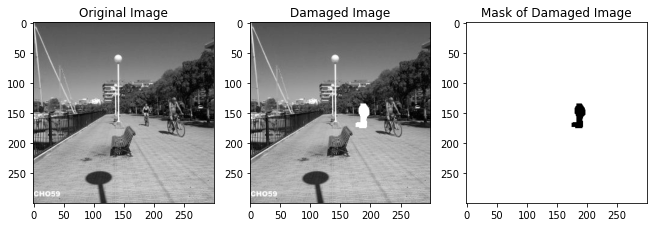

In [ ]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(original_img, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(img, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

#**TEST**

In [ ]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid(mask)
dsites = idx[mask]
epoints = idx[~mask]
rhs = rhs_function(img, mask)

result_image = HRBF2D(dsites, epoints, rhs, kernel)

img[~mask] = result_image

In [ ]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(original_img, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(img, cmap="gray"); plt.title("Result Image")